# Практика по PyTorch

<b>Цель.</b> Получить навыки практической работы с PyTorch.

<b>Описание/Пошаговая инструкция выполнения домашнего задания:</b>

<b>Используя PyTorch:</b>
1. Создать и обучить регрессионную модель, которая аппроксимирует значение функции sin(x + 2*y)exp(-(2x + y)^2) на диапазоне значений [-10;10] по х и у.
2. В качестве обучающей выборки необходимо сгенерировать 20000 точек случайным образом.
3. Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно.

<b>Результаты:</b>
</br>a) Посчитать метрику Mean Square Error(MSE) на test.
</br>b) Нарисовать график, в котором сравнивается истинная функция и ее аппроксимированный вариант (предсказываемый моделью).

# Выполнение

Импортируем основные библиотеки.

In [1]:
import torch
print (torch.cuda.is_available()) # Проверяем, доступно ли CUDA
print (torch.cuda.device_count()) # Выводим количество доступных GPU
print (torch.__version__) # Выводим версию PyTorch

True
1
2.3.0+cu118


In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt

Устанавливаем устройство (CPU или CUDA).

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Пишем функцию для генерации данных.


In [4]:
def generate_data(num_points=20000):
    # Генерируем случайные значения (массив из 20000 точек) для x и y в диапазоне [-10, 10]
    x = np.random.uniform(-10, 10, num_points)
    y = np.random.uniform(-10, 10, num_points)
    # Вычисляем значения функции для сгенерированных x и y
    z = np.sin(x + 2*y) * np.exp(-(2*x + y)**2)
    return x, y, z

Определяем регрессионную модель.

Модель будет состоять из трёх слоёв и 64 выходных нейронов в каждом слое (за исключением последнего).
Выбор трех слоев и 64 выходных нейронов в каждом слое (за исключением последнего) в контексте создания регрессионной модели — это относительно стандартный подход, который хорошо работает для многих задач.

<b>Три слоя:</b>
</br> Три слоя — это компромисс между сложностью модели и вычислительными затратами.
</br> Для многих задач регрессии три слоя достаточно для аппроксимации сложных нелинейных функций. Слишком малое количество слоев может не уловить все нюансы данных, а слишком большое — может привести к переобучению (overfitting) и увеличению времени обучения.
</br> В практике машинного обучения трехслойные сети часто показывают хорошие результаты. Если данные и модель правильно настроены, трехслойная сеть может эффективно обучаться и делать точные предсказания.

<b>64 нейрона на выходе:</b>
</br> В опыте многих исследований и практических применений количество нейронов, кратное 16 (например, 16, 32, 64, 128), часто демонстрирует хорошую производительность. 64 нейрона — это распространенный выбор, который обеспечивает баланс между вычислительными затратами и способностью модели обучаться.
</br> Использование слишком большого количества нейронов может привести к переобучению, где модель слишком хорошо подстраивается под обучающие данные и плохо работает на новых данных. 64 нейрона помогают избежать этого, оставаясь достаточно мощными для аппроксимации сложных функций.

In [5]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()

        # nn.Linear — это класс из библиотеки PyTorch, который используется для создания полносвязного слоя.
        # Он выполняет линейное преобразование входных данных, описываемое формулой
        # 𝑦=𝑥𝑊^𝑇+𝑏, где 𝑥 — входные данные, 𝑊 — матрица весов, а 𝑏 — вектор смещений.
        
        # Аргументы (2, 64). '2' — количество входных нейронов.
        # Это означает, что на вход данный слой принимает вектор из двух значений.
        # В данном контексте, это двухмерный вектор, содержащий значения 𝑥 и 𝑦.
        # '64' — количество выходных нейронов.
        # Это означает, что данный слой преобразует входной двухмерный вектор в выходной вектор, содержащий 64 значения.
        self.fc1 = nn.Linear(2, 64) # Первый полносвязный слой с 64 выходными нейронами
        self.fc2 = nn.Linear(64, 64) # Второй полносвязный слой с 64 выходными нейронами
        self.fc3 = nn.Linear(64, 1) # Третий полносвязный слой с 1 выходным нейроном
    
    def forward(self, x):
        x = torch.relu(self.fc1(x)) # Применяем функцию активации ReLU после первого слоя
        x = torch.relu(self.fc2(x)) # Применяем функцию активации ReLU после второго слоя
        x = self.fc3(x) # Выходной слой
        return x

Пишем основную функцию.

In [6]:
# Генерируем данные
x, y, z = generate_data(20000)

# Объединяем x и y в один массив данных для создания входных данных, которые будут подаваться в модель
# Объединение 𝑥 и 𝑦 в один массив с помощью np.vstack((x, y)).T преобразует наши данные в нужный формат.
# np.vstack((x, y)) создаёт массив из двух строк (одна для 𝑥, другая для 𝑦), а метод .T транспонирует его,
# чтобы получить массив, где каждая строка соответствует одной точке данных, содержащей 𝑥 и 𝑦.
data = np.vstack((x, y)).T

# Преобразуем z в вектор-столбец
# 'z' является одномерным массивом, содержащим значения функции, которые мы хотим предсказать.
# Преобразование z в вектор-столбец делает его совместимым с форматом,
# который ожидает модель и функции потерь (loss functions) в PyTorch.
targets = z.reshape(-1, 1)

# Преобразуем данные и цели в тензоры и перемещаем их на устройство
data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
targets_tensor = torch.tensor(targets, dtype=torch.float32).to(device)

# Создаем датасет из данных и целей
dataset = TensorDataset(data_tensor, targets_tensor)

# Определяем размеры выборок для обучения, валидации и тестирования
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Разделяем датасет на обучающую, валидационную и тестовую выборки
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Создаём загрузчики данных для каждой выборки
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Инициализируем модель, функцию потерь и оптимизатор
model = RegressionModel().to(device)
criterion = nn.MSELoss() # среднеквадратичная ошибка (Mean Squared Error, MSE)
# optimizer используется для настройки и оптимизации параметров модели во время обучения
# optimizer используется для обновления весов нейронной сети на основе градиентов,
# вычисленных во время обратного прохода (backpropagation).
# Цель оптимизатора — минимизировать значение функции потерь,
# чтобы модель делала как можно меньше ошибок на тренировочных данных.
# lr=0.001 задаёт начальную скорость обучения, определяющую величину шага обновления параметров на каждом этапе.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Определяем количество эпох обучения
# num_epochs задаёт количество эпох, в течение которых модель будет обучаться.
# В данном случае модель будет проходить через обучающий набор данных 100 раз.
num_epochs = 100

# Запускается цикл, который будет выполняться num_epochs раз (в данном случае 100 раз).
for epoch in range(num_epochs):
    # Устанавливаем модель в режим обучения. 
    # Это необходимо для активации определённых функций, таких как dropout, которые работают только в режиме обучения.
    model.train()
    
    # Запускается вложенный цикл, который проходит по всем батчам (пакетам данных) в train_loader.
    # train_loader — это загрузчик данных, который подаёт на вход модели части обучающего набора данных (батчи)
    # для ускорения процесса обучения.
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Перемещаем данные на устройство
        
        # Обнуляем градиенты, чтобы предотвратить накопление градиентов от предыдущих проходов.
        # В противном случае градиенты будут суммироваться, что приведёт к неправильному обновлению весов модели.
        optimizer.zero_grad()
        
        # Прямой проход (forward pass).
        # Входные данные inputs проходят через модель, чтобы получить предсказания outputs.
        outputs = model(inputs)
        
        # Вычисляем ошибку
        # Вычисляется ошибка между предсказаниями модели outputs и истинными значениями targets
        # с помощью функции потерь criterion (в данном случае nn.MSELoss()).
        loss = criterion(outputs, targets)
        
        # Обратный проход (backward pass)
        # loss.backward() вычисляет градиенты функции потерь по отношению к параметрам модели.
        # Эти градиенты используются для обновления весов модели.
        loss.backward()
        
        # Обновляем параметры модели
        # optimizer.step() обновляет параметры модели на основе вычисленных градиентов и алгоритма оптимизации
        # (в данном случае Adam).
        optimizer.step()

    # Проверяем модель на валидационных данных
    # Устанавливаем модель в режим оценки
    # Это деактивирует функции, такие как dropout, которые должны работать только в режиме обучения.
    model.eval()
    
    val_loss = 0 # Инициализация переменной для хранения общей ошибки
    with torch.no_grad(): # отключает вычисление градиентов, так как они не нужны при оценке модели.
        for inputs, targets in val_loader: # Проходится по всем батчам валидационного набора данных val_loader.
            inputs, targets = inputs.to(device), targets.to(device)  # Перемещаем данные на устройство
            outputs = model(inputs) # Вычисляются предсказания модели outputs для валидационных данных.
            loss = criterion(outputs, targets) # Вычисляется ошибка (функция потерь) для каждого батча.
            val_loss += loss.item() # Ошибка (функция потерь) для каждого батча суммируется в val_loss.
    val_loss /= len(val_loader) # Средняя ошибка val_loss вычисляется путём деления на количество батчей.
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

# Оцениваем модель на тестовых данных
# model.eval() Устанавливает модель в режим оценки (inference).
# Это важно, так как некоторые слои (например, BatchNorm, Dropout) ведут себя по-разному в режиме обучения и в режиме оценки.
# В режиме оценки они работают по-другому (например, не применяют dropout,
# а используют статистики, накопленные во время обучения).
model.eval()
test_loss = 0 # Инициализация переменной для хранения общей ошибки

# with torch.no_grad() Отключает вычисление градиентов, что уменьшает использование памяти и ускоряет вычисления.
# Во время оценки и предсказаний градиенты не нужны, так как мы не планируем обновлять параметры модели.
with torch.no_grad():
    for inputs, targets in test_loader: # Цикл проходит по всем батчам данных в тестовом загрузчике данных test_loader.
        inputs, targets = inputs.to(device), targets.to(device)  # Перемещаем данные на устройство
        outputs = model(inputs) # Для каждого батча данных модель делает предсказания, применяя прямой проход (forward pass).
        loss = criterion(outputs, targets) # Вычисляет MSE между предсказанными outputs и истинными targets значениями.
        # loss.item() Возвращает скалярное значение ошибки для текущего батча,
        # которое добавляется к общей сумме ошибок test_loss.
        test_loss += loss.item()
# test_loss Делит общую сумму ошибок на количество батчей, чтобы получить среднюю ошибку по всем тестовым данным.
test_loss /= len(test_loader)
print(f'Test MSE: {test_loss:.4f}')

Epoch 1/100, Validation Loss: 0.0163
Epoch 2/100, Validation Loss: 0.0152
Epoch 3/100, Validation Loss: 0.0161
Epoch 4/100, Validation Loss: 0.0148
Epoch 5/100, Validation Loss: 0.0141
Epoch 6/100, Validation Loss: 0.0151
Epoch 7/100, Validation Loss: 0.0140
Epoch 8/100, Validation Loss: 0.0133
Epoch 9/100, Validation Loss: 0.0135
Epoch 10/100, Validation Loss: 0.0126
Epoch 11/100, Validation Loss: 0.0126
Epoch 12/100, Validation Loss: 0.0129
Epoch 13/100, Validation Loss: 0.0122
Epoch 14/100, Validation Loss: 0.0121
Epoch 15/100, Validation Loss: 0.0122
Epoch 16/100, Validation Loss: 0.0122
Epoch 17/100, Validation Loss: 0.0121
Epoch 18/100, Validation Loss: 0.0116
Epoch 19/100, Validation Loss: 0.0119
Epoch 20/100, Validation Loss: 0.0116
Epoch 21/100, Validation Loss: 0.0120
Epoch 22/100, Validation Loss: 0.0112
Epoch 23/100, Validation Loss: 0.0119
Epoch 24/100, Validation Loss: 0.0112
Epoch 25/100, Validation Loss: 0.0113
Epoch 26/100, Validation Loss: 0.0107
Epoch 27/100, Validat

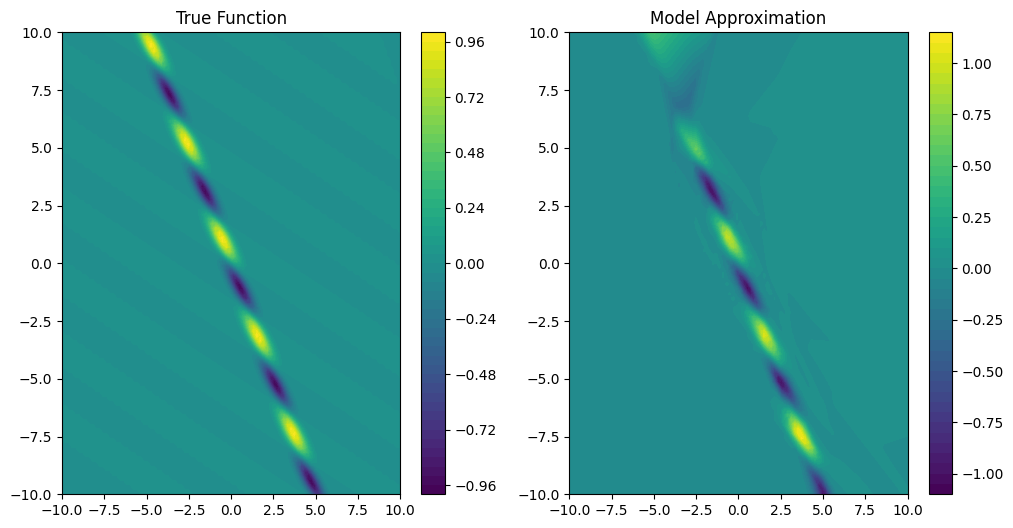

In [7]:
# Визуализация результатов
model.eval()
with torch.no_grad():
    # Генерируем сетку точек для визуализации функции
    test_x = np.linspace(-10, 10, 100)
    test_y = np.linspace(-10, 10, 100)
    grid_x, grid_y = np.meshgrid(test_x, test_y)
    grid_data = np.vstack((grid_x.flatten(), grid_y.flatten())).T
    grid_tensor = torch.tensor(grid_data, dtype=torch.float32).to(device)  # Перемещаем данные на устройство

    # Получаем предсказания модели
    predictions = model(grid_tensor).cpu().numpy().reshape(grid_x.shape)  # Перемещаем данные обратно на CPU для визуализации
    true_values = np.sin(grid_x + 2*grid_y) * np.exp(-(2*grid_x + grid_y)**2)

    # Строим графики
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.contourf(grid_x, grid_y, true_values, levels=50, cmap='viridis')
    plt.title('True Function')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.contourf(grid_x, grid_y, predictions, levels=50, cmap='viridis')
    plt.title('Model Approximation')
    plt.colorbar()

    plt.show()

<b>Итог:</b> Графики практически совпадают, это может свидетельствовать о хорошем качестве аппроксимации модели.